In [1]:
import os
from osgeo import gdal, ogr
import geopandas as gpd

files = os.listdir('shapes')

pd_shapes = {}
os_shapes = {}

for file in files:
    newfile = gpd.read_file(f'data/{file}')
    pd_shapes[str(file).replace('.shp', '')] = newfile

for file in files:
    newfile = ogr.Open(f'data/{file}')
    os_shapes[str(file).replace('.shp', '')] = newfile

os_shapes.keys()

: 

In [4]:
# BEAUTIFUL PLOT
import matplotlib.pyplot as plt

# # Plot the polygons first
# ax = shapes['TownBoundary'].plot(color='lightblue', edgecolor='black')

# # Plot the points on top of the polygons
# shapes['TownBoundary'].plot(ax=ax, marker='o', color='red', markersize=5)

# # Customize the plot (optional)
# plt.title('Polygons with Points Overlay')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# # Show the plot
# plt.show()

In [ ]:
# SAVING TO TIF raster files, 
#! all files are the same size & output
from osgeo import gdal, ogr
import numpy as np

rasters = {}
for key in os_shapes.keys():
    
    raster_file = f'rasters/{key}.tif'
    layer = os_shapes['Communityfeatures'].GetLayer()
    # Get the extent of the vector (bounding box)
    x_min, x_max, y_min, y_max = layer.GetExtent()

    # Define the resolution of the raster (pixels in x and y directions)
    pixel_size = 50  # adjust as needed
    x_res = int((x_max - x_min) / pixel_size)
    y_res = int((y_max - y_min) / pixel_size)

    # Create the output raster
    target_ds = gdal.GetDriverByName('GTiff').Create(raster_file, x_res, y_res, 1, gdal.GDT_Byte)

    # Set the transformation (georeferencing)
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

    # Get raster band
    band = target_ds.GetRasterBand(1)
    band.Fill(0)  # Initialize raster with zeros
    band.SetNoDataValue(0)  # Set no-data value

    # Rasterize the layer
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[1])

    # Close datasets
    target_ds = None
    vector_source = None

    print(f"Rasterization complete. Output saved at {raster_file}.")

In [1]:
#Communityfeatures euclidean distance rasterization

raster_file = f'rasters/{key}.tif'
layer = os_shapes['Communityfeatures'].GetLayer()

# Get the extent of the vector (bounding box)
x_min, x_max, y_min, y_max = layer.GetExtent()

# Define the resolution of the raster (pixels in x and y directions)
pixel_size = 50  # Adjust as needed
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)

# Create the output raster
target_ds = gdal.GetDriverByName('GTiff').Create(raster_file, x_res, y_res, 1, gdal.GDT_Float32)

# Set the transformation (georeferencing)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

# Get raster band
band = target_ds.GetRasterBand(1)
band.Fill(0)  # Initialize raster with zeros
band.SetNoDataValue(0)  # Set no-data value

# Initialize an array to store the weighted distance results
distance_raster = np.zeros((y_res, x_res), dtype=np.float32)

# For each feature (point) in the layer, calculate the Euclidean distance and adjust the weight
for feature in layer:
    geom = feature.GetGeometryRef()
    weight = feature.GetField('weight')  # Replace 'weight' with the actual column name

    # Rasterize the point feature to create a temporary mask (value=1 where the point is)
    temp_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, 1, gdal.GDT_Byte)
    temp_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    temp_band = temp_ds.GetRasterBand(1)
    temp_band.Fill(0)  # Initialize with zeros
    gdal.RasterizeLayer(temp_ds, [1], layer, burn_values=[1])

    # Read the temporary rasterized point data into an array
    point_mask = temp_band.ReadAsArray()

    # Compute Euclidean distance from the point
    distance = distance_transform_edt(point_mask == 0)

    # Apply the weight reduction formula (e.g., weight / distance)
    weighted_distance = np.where(distance > 0, weight / distance, weight)

    # Combine the weighted distance for this point into the main raster
    distance_raster = np.maximum(distance_raster, weighted_distance)  # Take the max of weighted distances

# Write the combined weighted distance raster to the output
band.WriteArray(distance_raster)

# Close datasets
target_ds = None
vector_source = None

print(f"Weighted Euclidean distance rasterization complete. Output saved at {raster_file}.")

NameError: name 'key' is not defined

In [ ]:
# testing drawing a better raster
import rasterio
from rasterio import features
import geopandas as gpd
import numpy as np

def rasterize_shapefile(shapefile_path, output_path, pixel_size=50):
    """
    Rasterize a shapefile and save it as a GeoTIFF.
    
    Parameters:
    shapefile_path (str): Path to input shapefile
    output_path (str): Path for output raster
    pixel_size (float): Size of pixels in map units
    """
    # Read the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Get the bounds
    bounds = gdf.total_bounds
    
    # Calculate raster dimensions
    width = int((bounds[2] - bounds[0]) / pixel_size)
    height = int((bounds[3] - bounds[1]) / pixel_size)
    
    # Create the transform
    transform = rasterio.transform.from_bounds(
        bounds[0], bounds[1], bounds[2], bounds[3], width, height
    )
    
    # Rasterize the shapes
    shapes = ((geom, 1) for geom in gdf.geometry)
    raster = features.rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype=np.uint8
    )
    
    # Save the raster
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=np.uint8,
        crs=gdf.crs,
        transform=transform,
    ) as dst:
        dst.write(raster, 1)
        
rasterize_shapefile(
    "path/to/your/shapefile.shp",
    "output/raster.tif",
    pixel_size=50
)

Text(0.5, 1.0, 'Raster Plot')

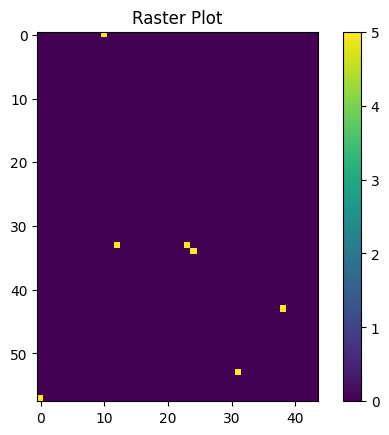

In [30]:
# plot the raster
import matplotlib.pyplot as plt

# Open the raster file
raster = gdal.Open('rasters/Communityfeatures.tif')

# Get the raster data
data = raster.ReadAsArray()

# Plot the raster
plt.imshow(data)
plt.colorbar()
plt.title('Raster Plot')


Text(0.5, 1.0, 'Raster Plot')

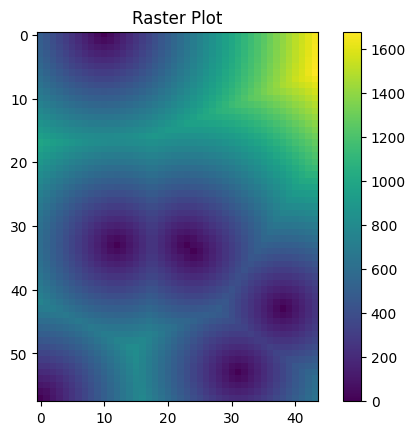

In [31]:
# plot the raster
import matplotlib.pyplot as plt

# Open the raster file
raster = gdal.Open('rasters/Communityfeatures_distance.tif')

# Get the raster data
data = raster.ReadAsArray()

# Plot the raster
plt.imshow(data)
plt.colorbar()
plt.title('Raster Plot')